In [2]:
import sys
import copy

import torch
import torchvision
from torch.utils.data import RandomSampler
from tqdm import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')
from dataset import EncodeDataset
from dataset import LargeRandomSampler, encode_worker_init_fn
from train.train_encode_dataset import TrainEncodeDatasetModel
from deepct_model import DeepCT, criterion

import selene_sdk
from data.utils import interval_from_line
from src.utils import expand_dims
from src.transforms import PermuteSequenceChannels, RandomReverseStrand, MaskTracks, MaskFeatures
from src.notebook_utils import load_datasets, get_loader

In [8]:
device = torch.device('cuda:2')

In [4]:
boix_folder = '/mnt/datasets/DeepCT/dataset_data/Biox_et_al'

track_mask = np.load('/mnt/datasets/DeepCT/drop_tracks756.npy')
train_transform = torchvision.transforms.Compose([
    PermuteSequenceChannels(),
    RandomReverseStrand(p=0.5),
    MaskTracks(track_mask)
])

feature_mask = np.load('/mnt/datasets/DeepCT/dataset_data/Biox_et_al/not_top4_feature_mask.npy')
val_transform = torchvision.transforms.Compose([
    PermuteSequenceChannels(),
    #MaskFeatures(feature_mask)
])

In [7]:
boix_train, boix_val, boix_test = load_datasets(
    boix_folder, train=True, val=True, test=True, 
    train_transform=train_transform, val_transform=val_transform)
boix_val_loader = get_loader(boix_val, batch_size=128, shuffle=1448)
boix_train_loader = get_loader(boix_train, batch_size=128, shuffle=1447)

In [29]:
boix_cell_types = boix_val._cell_types
boix_target_features = boix_val.target_features
boix_track_matrix = boix_val._feature_indices_by_cell_type_index

n_cell_types = len(boix_cell_types)
n_features = len(boix_target_features)

In [9]:
chkpnt_path = '/home/msindeeva/DeepCT/DeepCT_outputs/boix/ct_v2/all/multi_ct/AdamW_COS_LR0001/2021-05-31-20-28-42/best_model.pth.tar'
all_boix_chckpnt = torch.load(chkpnt_path, map_location=device)

In [21]:
from src.deepct_model_multi_ct import DeepCT
model = DeepCT(
    sequence_length=1000,
    n_cell_types=858,
    sequence_embedding_length=256,
    cell_type_embedding_length=32,
    final_embedding_length=256,
    n_genomic_features=40,
)
model.to(device)
model.load_state_dict(all_boix_chckpnt['state_dict'])
model.eval()
print('Model loaded successfully!')

DeepCT(
  (conv_net): Sequential(
    (0): Conv1d(4, 320, kernel_size=(8,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(320, 320, kernel_size=(8,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv1d(320, 480, kernel_size=(8,), stride=(1,))
    (7): ReLU(inplace=True)
    (8): Conv1d(480, 480, kernel_size=(8,), stride=(1,))
    (9): ReLU(inplace=True)
    (10): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm1d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout(p=0.2, inplace=False)
    (13): Conv1d(480, 960, kernel_size=(8,), stride=(1,))
    (14): ReLU(inplace=True)
    (15): Conv1d(960, 960, kernel_size=(8,), stride=(1,))
    (16): ReLU(inplace=True)
    (17): BatchNorm1d(960, eps=1e-05, momentum=0.1, affine=True,

In [87]:
gts = []
preds = []
masks = []
for i, batch in enumerate(boix_val_loader):
    if i == 50:
        break
    pred = torch.sigmoid(model(batch[0].to(device)))
    preds.append(pred.detach().cpu().numpy())
    gts.append(batch[2].view(-1, n_features).numpy())
    masks.append(batch[3].view(-1, n_features).numpy())
preds = np.concatenate(preds)
masks = np.concatenate(masks)
gts = np.concatenate(gts)

In [42]:
import seaborn as sns

In [107]:
def draw_feature_preds_hist(feat_preds, feat_gts, threshold, ax=None, feature_name=0):
    ax.hist(feat_preds, color='tab:blue')
    ax.hist(feat_gts, color='tab:purple', alpha=0.5)
    ax.axvline(threshold[0], c='tab:red')
    ax.axvline(threshold[1], c='tab:red')
    lower = (feat_preds < threshold[0]).sum()
    upper = (feat_preds > threshold[1]).sum()
    percent_preds = (lower + upper) / feat_preds.shape[0] * 100
    
    ax.set_xlim(0, 1)
    ax.set_ylim()

    ax.set_title(f"Feature {feature_name}; <{threshold[0]:.1f}: {lower}; >{threshold[1]:.1f}: {upper}; %: {percent_preds:2.2f}%")

In [115]:
from src.metrics import accuracy_score, jaccard_score

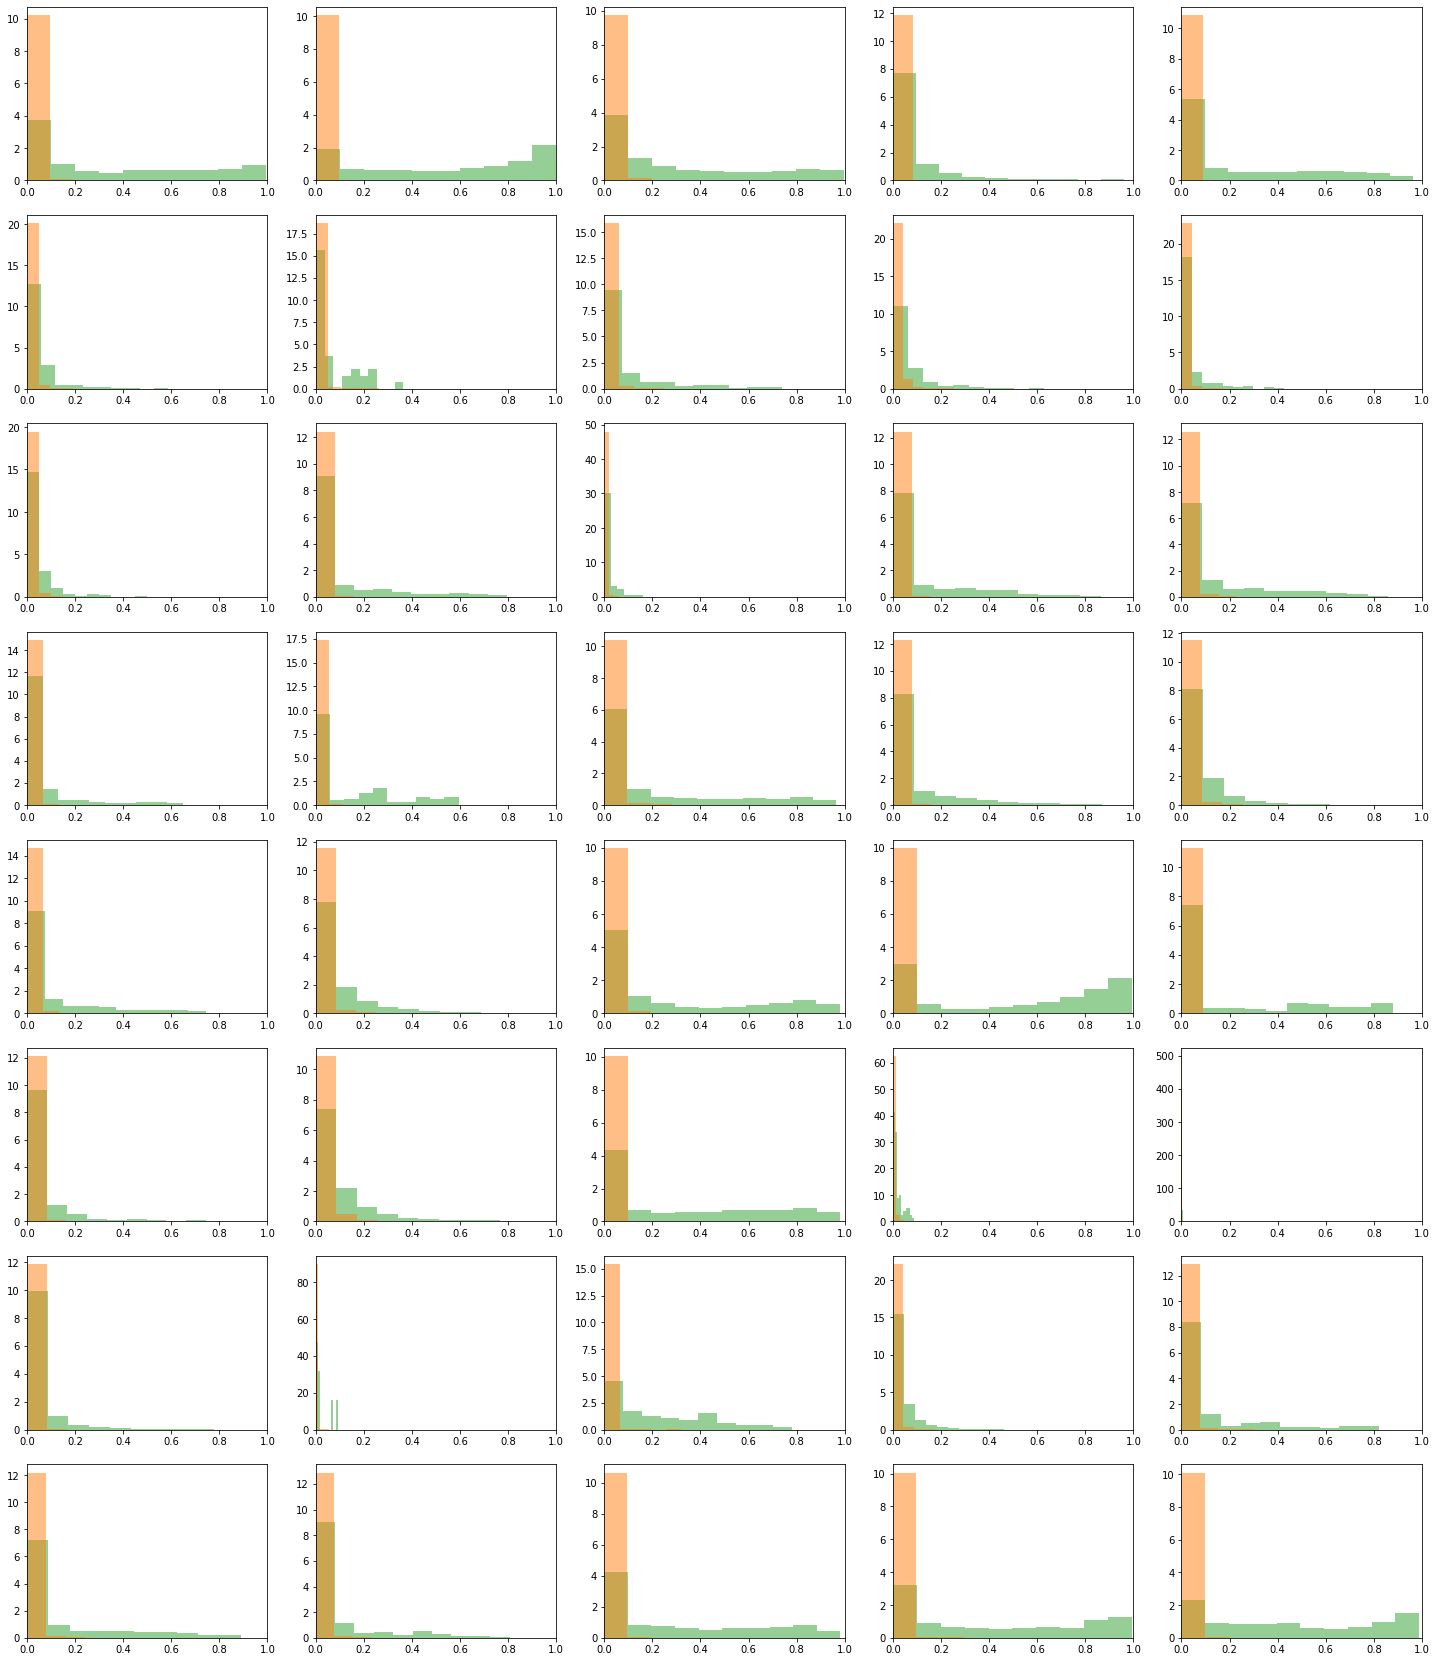

In [135]:
thresholds = [(0.1, 0.9), (0.2, 0.8), (0.3, 0.7), (0.4, 0.6), 0.3, 0.5, (0.1, 0.3), (0.2, 0.3), (0.1, 0.2)]
accs = []
shares = []
jaccards = []
for threshold in thresholds:
    threshold = (0.1, 0.9)
    fig, ax = plt.subplots(8, 5, figsize=(25, 30))
    feat_accs = []
    feat_shares = []
    feat_jaccards = []
    for feature in range(n_features):
        axes = ax[feature // 5][feature % 5]

        feat_masks = masks[..., feature]
        feat_preds = preds[..., feature][feat_masks]
        feat_gts = gts[..., feature][feat_masks]
        ones_preds = feat_preds[feat_gts == 1]
        zero_preds = feat_preds[feat_gts == 0]
        
        if not isinstance(threshold, float):
            lower = (feat_preds < threshold[0]).sum()
            upper = (feat_preds > threshold[1]).sum()
            percent_preds = (lower + upper) / feat_preds.shape[0]
        else:
            percent_preds = 1.
        feat_shares.append(percent_preds)

        jaccard = jaccard_score(feat_gts, feat_preds, threshold=threshold)
        feat_jaccards.append(jaccard)
        acc = accuracy_score(feat_gts, feat_preds, threshold=threshold)
        feat_accs.append(acc)
        
        axes.hist(ones_preds, color='tab:green', alpha=0.5, density=True)
        axes.hist(zero_preds, color='tab:orange', alpha=0.5, density=True)
        axes.set_xlim(0, 1)
        

        #draw_feature_preds_hist(feat_preds, feat_gts, threshold, ax=axes, feature_name=feature)
    plt.show()
    break
    accs.append(feat_accs)
    shares.append(feat_shares)
    jaccards.append(feat_jaccards)

In [127]:
accs = np.array(accs)
shares = np.array(shares)
jaccards = np.array(jaccards)

In [131]:
for i, threshold in enumerate(thresholds):
    print(f'Threshold: {threshold}')
    print(f'Mean jaccard: {jaccards[i].mean():.2f}')
    print(f'Mean acc: {accs[i].mean():.2f}')
    print(f'Mean share: {shares[i].mean():.2f}')
    print('--------------------')

Threshold: (0.1, 0.9)
Mean jaccard: 0.05
Mean acc: 0.99
Mean share: 0.99
--------------------
Threshold: (0.2, 0.8)
Mean jaccard: 0.07
Mean acc: 0.99
Mean share: 0.99
--------------------
Threshold: (0.3, 0.7)
Mean jaccard: 0.09
Mean acc: 0.99
Mean share: 1.00
--------------------
Threshold: (0.4, 0.6)
Mean jaccard: 0.10
Mean acc: 0.99
Mean share: 1.00
--------------------
Threshold: 0.3
Mean jaccard: 0.16
Mean acc: 0.99
Mean share: 1.00
--------------------
Threshold: 0.5
Mean jaccard: 0.11
Mean acc: 0.99
Mean share: 1.00
--------------------
Threshold: (0.1, 0.3)
Mean jaccard: 0.18
Mean acc: 0.99
Mean share: 0.99
--------------------
Threshold: (0.2, 0.3)
Mean jaccard: 0.16
Mean acc: 0.99
Mean share: 1.00
--------------------
Threshold: (0.1, 0.2)
Mean jaccard: 0.19
Mean acc: 0.99
Mean share: 0.99
--------------------
